### Time to get your hands dirty! Supernova distances and redshifts (part 2)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

(35.0, 50.0)

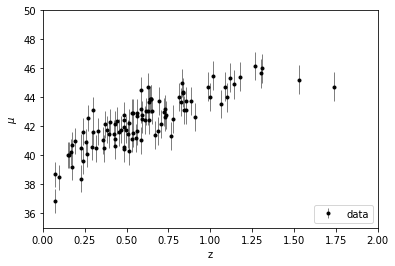

In [6]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

First let's fit our supernova synthetic data from last time using GPR.

- The key ingrediente in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

We now have a suite of *data-drive predictive models* for our supernova dataset. That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM.

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy?

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much better.
- Assume a uniform distribution in redshifts between 0 and z.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 




--------
## My implementation

In [47]:
pip install scikit-learn  -U

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 10.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 5.4 MB/s eta 0:00:0000:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully unin

In [1]:
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor,kernels
from astropy.cosmology import FlatLambdaCDM
from astroML import stats as astroMLstats
import dynesty
from dynesty import plotting as dyplot
import scipy
import corner


from sklearn.model_selection import train_test_split

color = ['#F5793A', '#A95AA1', '#85C0F9', '#0F2080']

In [2]:
''' computes the rms error'''
def rms_error(x, y, clf):
    return np.sqrt(np.sum((clf.predict(x) - y) ** 2)
                   / len(y))

### Theoretical model

In [3]:
# Model
def distmodz(par, z):
    H0, Om = par
    
    # Flat universe model
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om)
    
    # distance modulus in magnitudes
    mu_predicted = cosmo.distmod(z).value
    return mu_predicted

/usr/local/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1280: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


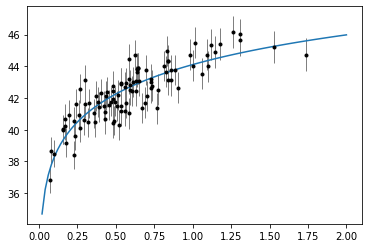

In [7]:
# Theoretical model
zgrid = np.linspace(0,2,100)
p0 = [71, 0.27]
mumodel = distmodz(p0, zgrid)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='observations')
plt.plot(zgrid, mumodel)

### GRP

##### Cross-validation

In [9]:
sigma = kernels.ConstantKernel(1) 
length_low = np.logspace(-5, 0, 40)
length_high = np.logspace(0, 5, 40)

cverr_gpr = np.zeros([len(length_low ), len(length_high)])
trainerr_gpr = np.zeros([len(length_low), len(length_high)])

for i,llow in enumerate(length_low):
    for j,lhigh in enumerate(length_high):
        if lhigh >= llow:
            l = np.mean([llow, lhigh])
            kf = KFold(n_splits=5, shuffle=True, random_state=5)
            cverr = []
            trainerr = []
        
            kernel = kernels.RBF(l, (llow, lhigh)) 
        
            for train_index, cv_index in kf.split(z_sample):
                X_train, X_cv = z_sample[train_index], z_sample[cv_index]
                y_train, y_cv = mu_sample[train_index], mu_sample[cv_index]
                dy_train, dy_cv = dmu[train_index], dmu[cv_index]
            
                gpr = GaussianProcessRegressor(kernel= sigma**2 * kernel, alpha = (dy_train) ** 2)
                #print(X_train, '\n \n',y_train)
                gpr.fit(X_train[:, np.newaxis], y_train)
            
                trainerr.append(rms_error(X_train[:, np.newaxis], y_train, gpr))
                cverr.append(rms_error(X_cv[:, np.newaxis], y_cv, gpr))
        
            cverr_gpr[i][j] = np.median(cverr)
            trainerr_gpr[i][j] = np.median(trainerr)
                                         

                
#np.where(cverr_gpr == min(cverr_gpr))
print(np.where(cverr_gpr ==  np.min(cverr_gpr))[0])
print(np.where(cverr_gpr ==  np.min(cverr_gpr))[1])

llow_best = length_low[np.where(cverr_gpr ==  np.min(cverr_gpr))[1][0]]
lhigh_best = length_high[np.where(cverr_gpr == np.min(cverr_gpr))[0][0]]

/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The op

[34]
[0]


In [10]:
print('best l: \n low bound: ', llow_best, '\n high bound:',lhigh_best);

best l: 
 low bound:  1e-05 
 high bound: 22854.638641349884


#### Regression

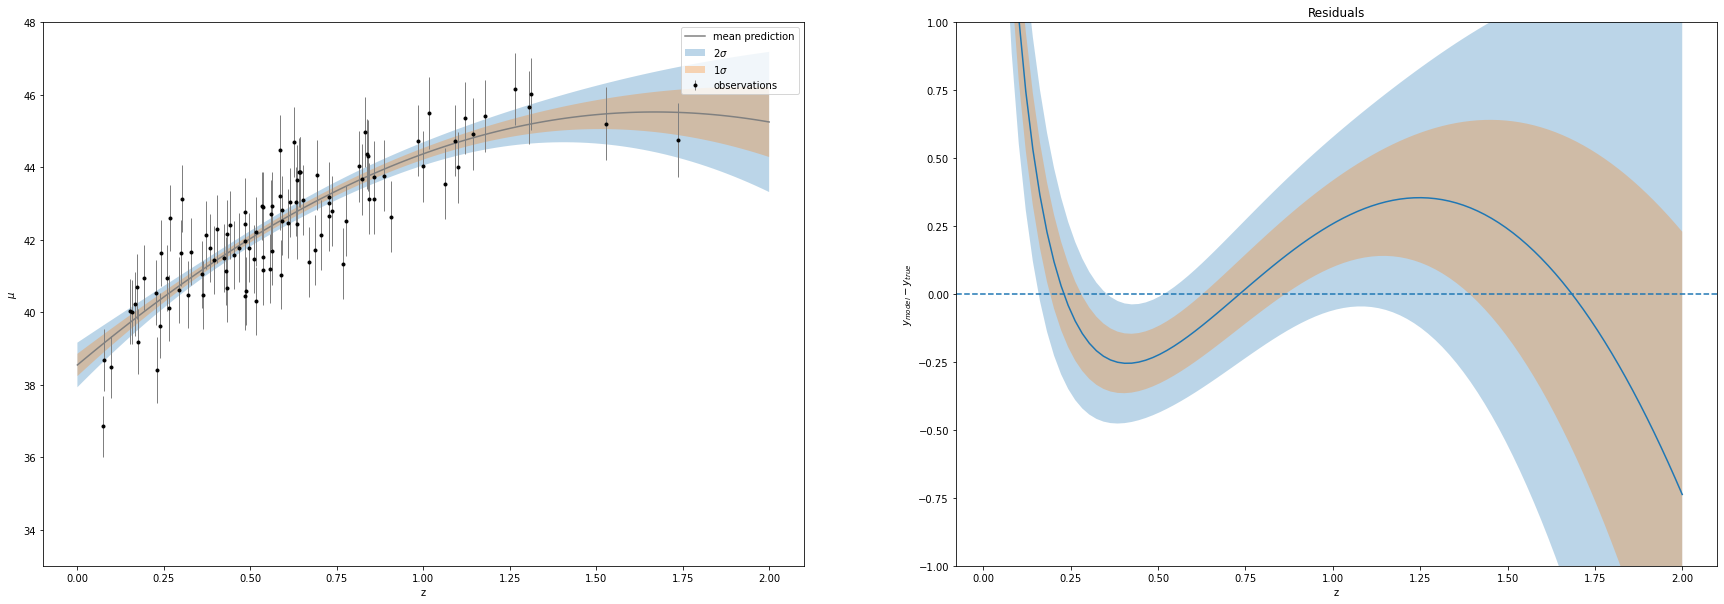

In [56]:
kernel = kernels.RBF(np.mean([llow_best,lhigh_best]), (llow_best,lhigh_best)) 
sigma = kernels.ConstantKernel(1)  

gpr = GaussianProcessRegressor(kernel=sigma**2 * kernel,    #alpha to implement error
                               alpha= (dmu) ** 2,
                               random_state=8)
gpr.fit(z_sample[:, np.newaxis],mu_sample)


# plot the results
xgrid = np.linspace(0,2,100)
f, ferr = gpr.predict(xgrid[:, None], return_std=True) 

fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(121)
plt.plot(xgrid, f, color='gray', label='mean prediction')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='observations')
plt.fill_between(xgrid.ravel(),
                 f - 2 * ferr, f + 2 * ferr, 
                 alpha=0.3, label=r"2$\sigma$")
plt.fill_between(xgrid.ravel(),
                 f - 1 * ferr, f + 1 * ferr, 
                 alpha=0.3, label=r"1$\sigma$")

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.ylim(33,48)
plt.legend()

ax2 = fig.add_subplot(122)
plt.plot(zgrid, f-mumodel)
plt.fill_between(xgrid.ravel(),
                 (f - 2 * ferr)-mumodel, (f + 2 * ferr)-mumodel, 
                 alpha=0.3, label=r"2$\sigma$")
plt.fill_between(xgrid.ravel(),
                 (f - 1 * ferr)-mumodel, (f + 1 * ferr)-mumodel, 
                 alpha=0.3, label=r"1$\sigma$")
plt.axhline(0, 3, 0, linestyle='--')
plt.ylim(-1,1)    
plt.ylabel(r'$y_{model}-y_{true}$')
plt.xlabel('z')
plt.title('Residuals');

### Nested Sampling

In [12]:
# problem dimensionality
ndim = 2


# prior
def prior(u):
    #H0 = scipy.stats.loguniform.ppf(u[0], np.exp(0), np.exp(200))
    #Om = scipy.stats.loguniform.ppf(u[1], np.exp(0), np.exp(1)) 
    H0 = u[0]*700
    Om = u[1]
    
    par = np.array([H0, Om])   
    return(par)


#likelihood
def loglike(par):
    mufit = distmodz(par, z_sample)
    return - 0.5 * np.sum((mu_sample-mufit)**2/(dmu**2)) 

In [13]:
sampler = dynesty.NestedSampler(loglike, prior, ndim)
sampler.run_nested()
results = sampler.results

2951it [00:35, 83.48it/s, +500 | bound: 3 | nc: 1 | ncall: 21710 | eff(%): 16.271 | loglstar:   -inf < -46.386 <    inf | logz: -51.431 +/-  0.086 | dlogz:  0.001 >  0.509]


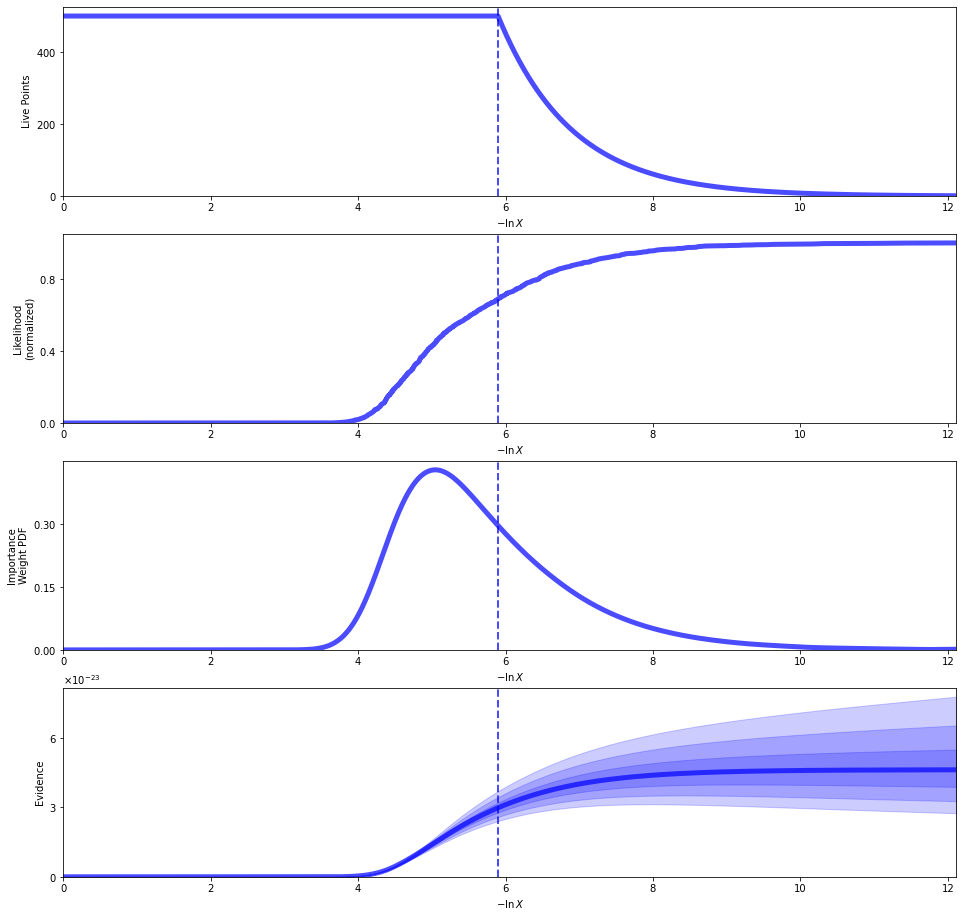

In [14]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

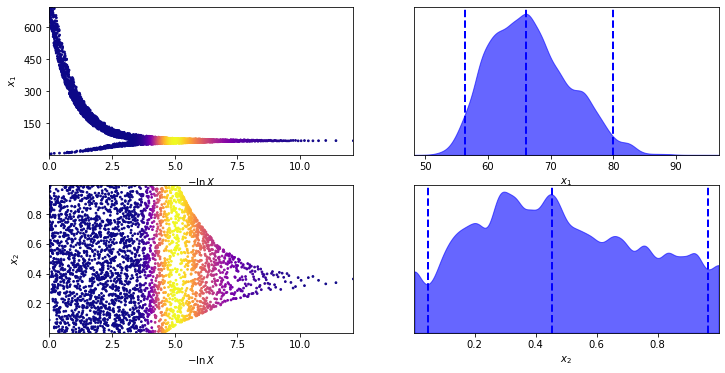

In [15]:
tfig, taxes = dyplot.traceplot(results)

In [16]:
# Extract samples
samples = results.samples
print(samples.shape)


#cumulative evidence
cumevidence = np.exp(results.logz)   
#print(cumevidence.shape, cumevidence)


# weight (unnormalized) associated to each sample
weights = np.exp(results.logwt)   
weights /= cumevidence[-1]  #normalized now


#resample the run so that all points have equal weight
sample = dynesty.utils.resample_equal(samples, weights)

(3451, 2)


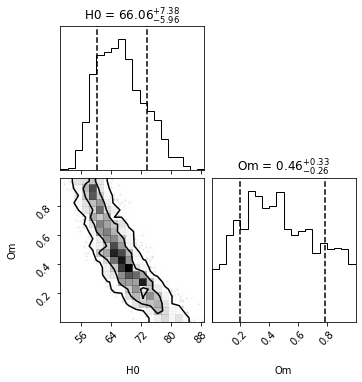

In [17]:
corner.corner(sample, labels=['H0', 'Om'], 
            levels = [0.68, 0.95], quantiles=[0.16, 0.84],
            show_titles=True);

/usr/local/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1280: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/usr/local/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1280: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/usr/local/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1280: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/usr/local/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1280: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/usr/local/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1280: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/usr/local/lib/python3.9/site-packages/a

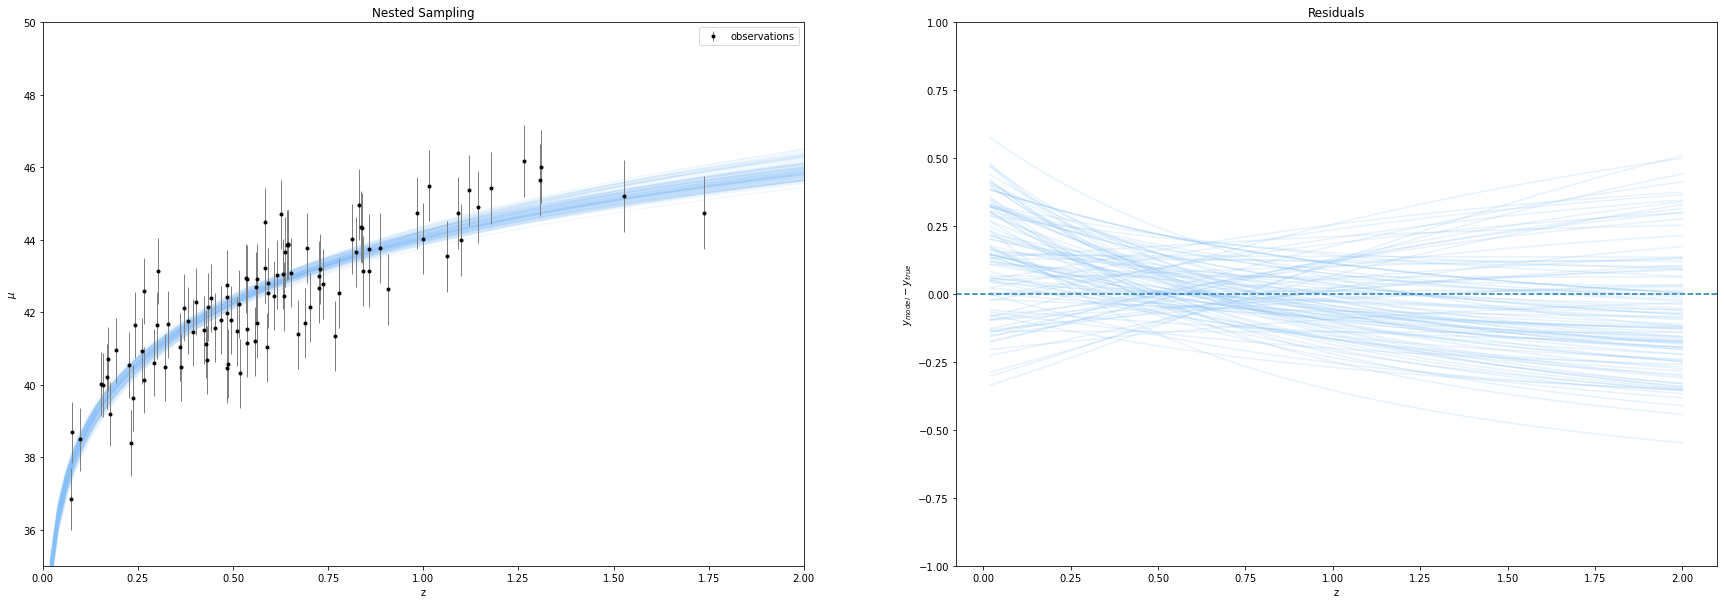

In [68]:
sample100 = sample[np.random.choice(range(len(sample)), 100)]

fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(121)

for H0, Om in sample100:
    par = [H0, Om]
    model100 = distmodz(par, zgrid)
    plt.plot(zgrid, model100, color=color[2], alpha=0.1);

# Nested sampling

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='observations')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Nested Sampling')

plt.legend();


ax2 = fig.add_subplot(122)

for H0, Om in sample100:
    par = [H0, Om]
    model100 = distmodz(par, zgrid)
    plt.plot(zgrid, model100-mumodel, color=color[2], alpha=0.2);
    
plt.axhline(0, 3, 0, linestyle='--')
plt.ylim(-1,1)    
plt.ylabel(r'$y_{model}-y_{true}$')
plt.xlabel('z')
plt.title('Residuals');

#### Model with no dark energy

In [33]:
# Model
def distmodzOm1(H0, z):
    
    # Flat universe model
    cosmo = FlatLambdaCDM(H0=H0, Om0=1)
    
    # distance modulus in magnitudes
    mu_predicted = cosmo.distmod(z).value
    return mu_predicted


def priorOm1(u):
    H0 = scipy.stats.loguniform.ppf(u[0], np.exp(0), np.exp(10))
    #Om = scipy.stats.loguniform.ppf(u[1], np.exp(0), np.exp(1)) 
    #H0 = u[0]*700
     
    return(H0)

#likelihood
def loglikeOm1(par):
    mufit = distmodzOm1(par, z_sample)
    return - 0.5 * np.sum((mu_sample-mufit)**2/(dmu**2)) 

In [34]:
samplerOm1 = dynesty.NestedSampler(loglikeOm1, priorOm1, ndim)
samplerOm1.run_nested()
resultsOm1 = samplerOm1.results

2692it [00:34, 77.15it/s, +500 | bound: 3 | nc: 1 | ncall: 19922 | eff(%): 16.435 | loglstar:   -inf < -47.102 <    inf | logz: -51.578 +/-  0.076 | dlogz:  0.001 >  0.509]


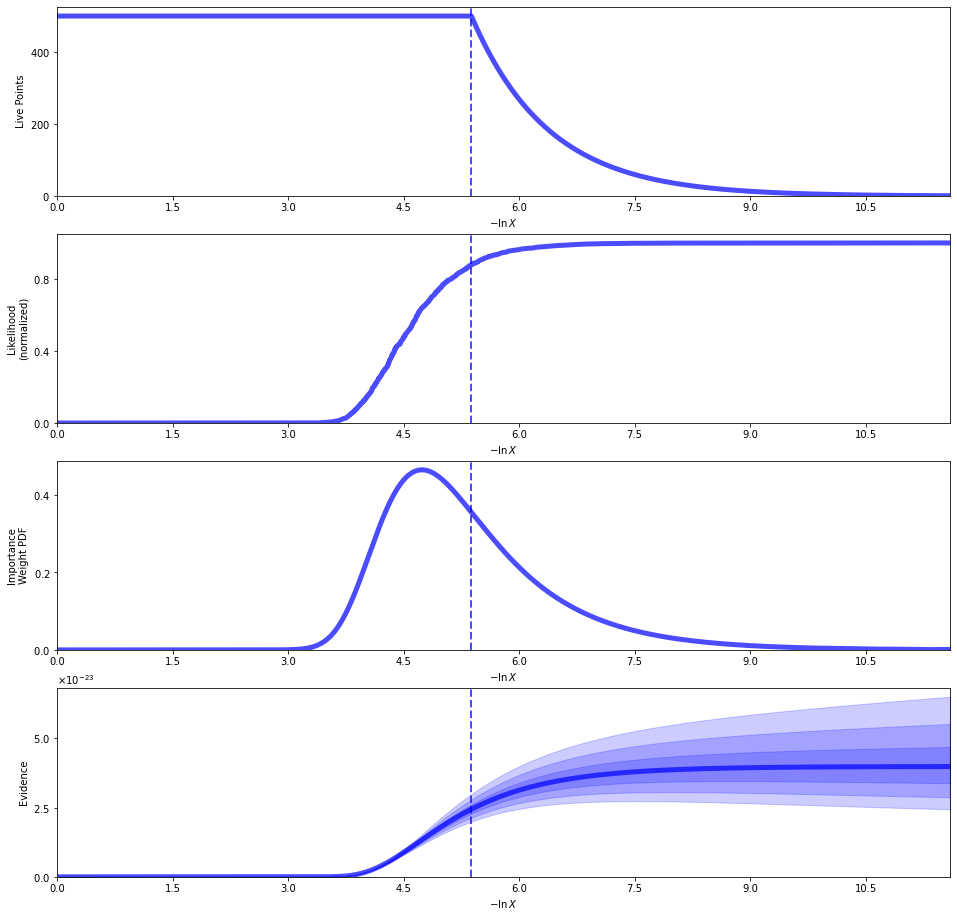

In [35]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(resultsOm1)

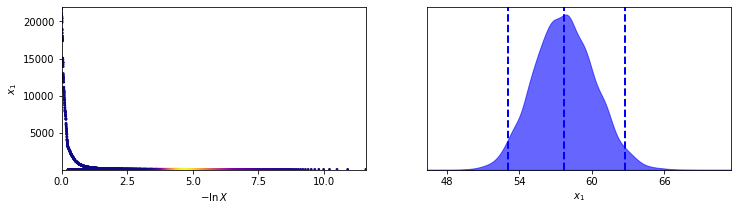

In [37]:
tfig, taxes = dyplot.traceplot(resultsOm1)

In [38]:
# Extract samples
samplesOm1 = resultsOm1.samples
print(samplesOm1.shape)


#cumulative evidence
cumevidenceOm1 = np.exp(resultsOm1.logz)   
#print(cumevidence.shape, cumevidence)


# weight (unnormalized) associated to each sample
weights = np.exp(resultsOm1.logwt)   
weights /= cumevidence[-1]  #normalized now

#resample the run so that all points have equal weight
sampleOm1 = dynesty.utils.resample_equal(samplesOm1, weights)

(3192,)


/usr/local/lib/python3.9/site-packages/dynesty/utils.py:1029: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


/usr/local/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1280: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/usr/local/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1280: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/usr/local/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1280: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/usr/local/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1280: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/usr/local/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1280: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/usr/local/lib/python3.9/site-packages/a

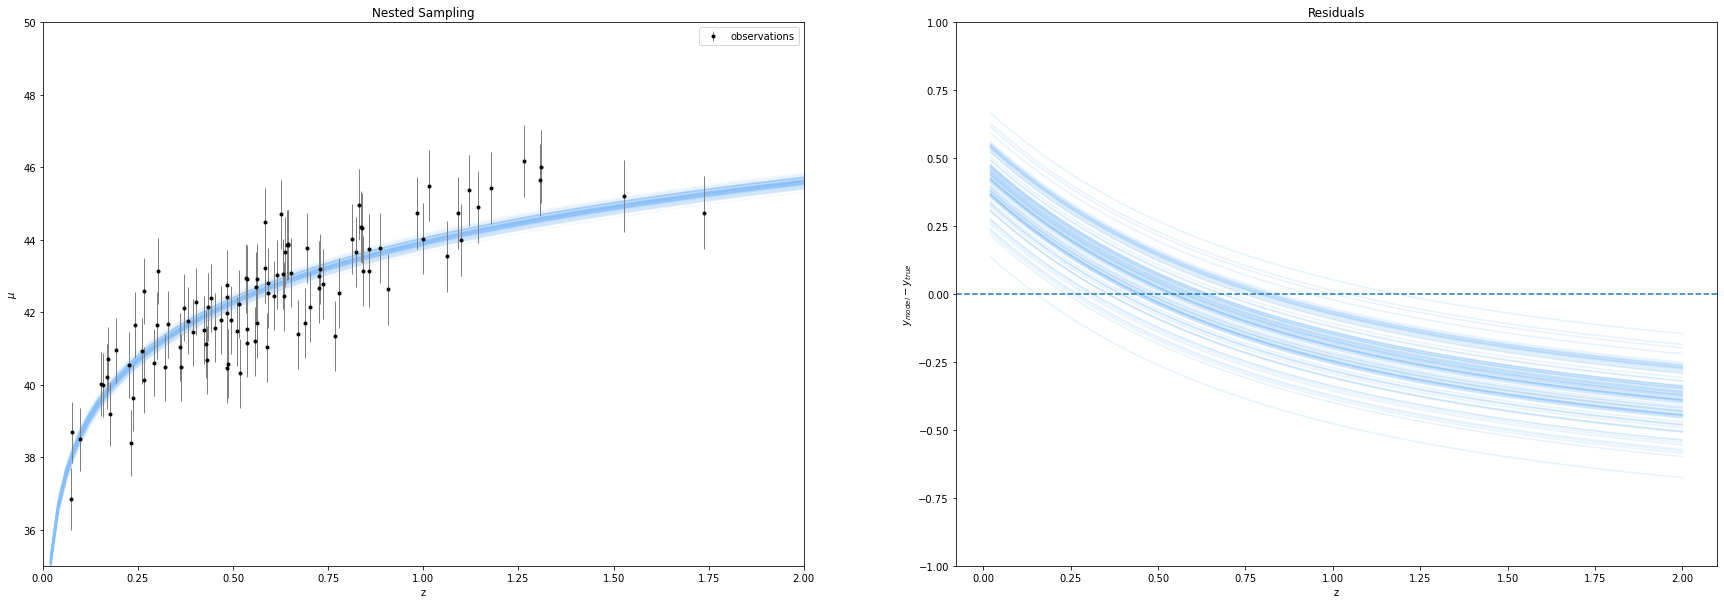

In [66]:
sampleOm1100 = sampleOm1[np.random.choice(range(len(sampleOm1)), 100)]

fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(121)
for H0 in sampleOm1100:
    model100 = distmodzOm1(H0, zgrid)
    plt.plot(zgrid, model100, color=color[2], alpha=0.1);

# Nested sampling
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='observations')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Nested Sampling')

plt.legend()


ax2 = fig.add_subplot(122)
for H0 in sampleOm1100:
    model100 = distmodzOm1(H0, zgrid)
    plt.plot(zgrid, model100-mumodel, color=color[2], alpha=0.2);
plt.axhline(0, 3, 0, linestyle='--')
plt.ylim(-1,1)    
plt.ylabel(r'$y_{model}-y_{true}$')
plt.xlabel('z')
plt.title('Residuals');

##### Compare models

/usr/local/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1280: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


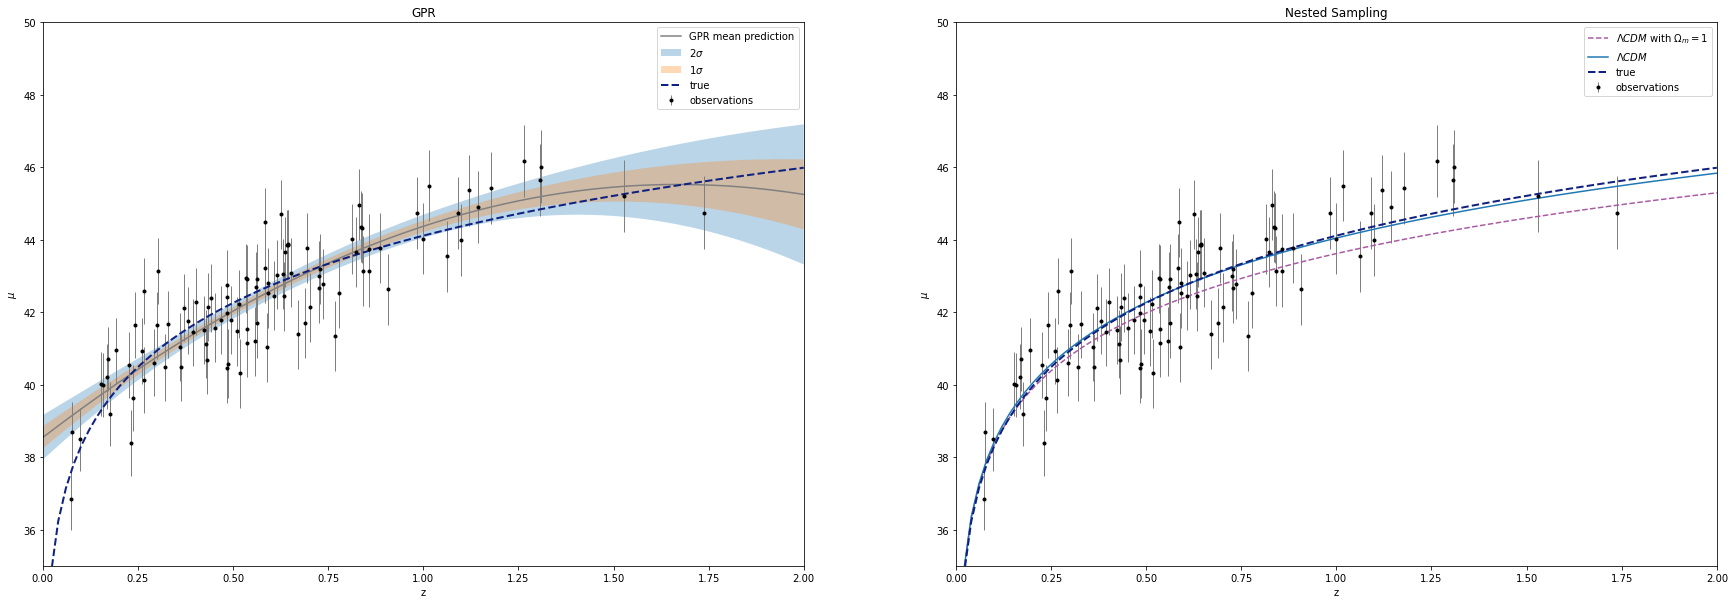

In [326]:
zgrid = np.linspace(0,2,100)

# theoretical model
p0 = [71, 0.27]
true_mu = distmodz(p0, zgrid)

# model with NS
Om = np.median(sample[:,1])
H0 = np.median(sample[:,0])
p = [H0, Om]
mu = distmodz(p, zgrid)


# model with NS, no dark energy
Om = 1.
H0Om1 = np.median(sampleOm1)
pOm1 = [H0, Om]
muOm1 = distmodz(pOm1, zgrid)


# -------------------plot ----------------

# GPR
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(121)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='observations')
plt.plot(xgrid, f, color='gray', label='GPR mean prediction')
plt.fill_between(xgrid.ravel(),
                 f - 2 * ferr, f + 2 * ferr, 
                 alpha=0.3, label=r"2$\sigma$")
plt.fill_between(xgrid.ravel(),
                 f - 1 * ferr, f + 1 * ferr, 
                 alpha=0.3, label=r"1$\sigma$")
plt.plot(zgrid, true_mu, linestyle='--',label='true', color=color[3], lw=2)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('GPR')

plt.legend();



# Nested sampling
ax2 = fig.add_subplot(122)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='observations')
plt.plot(zgrid, muOm1, '--', color=color[1], label=r'$\Lambda CDM$ with $\Omega_{m}=1$')
plt.plot(zgrid, mu, label=r'$\Lambda CDM$')
plt.plot(zgrid, true_mu, linestyle='--',label='true', color=color[3], lw=2)

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Nested Sampling')

plt.legend();

What Bayes factor says about the best model? 

In [436]:
BayesFactor =  cumevidence[-1]/cumevidenceOm1[-1]
print(BayesFactor)

1.6172272172102948


Model with dark energy is not favoured in this case!

### Clone data

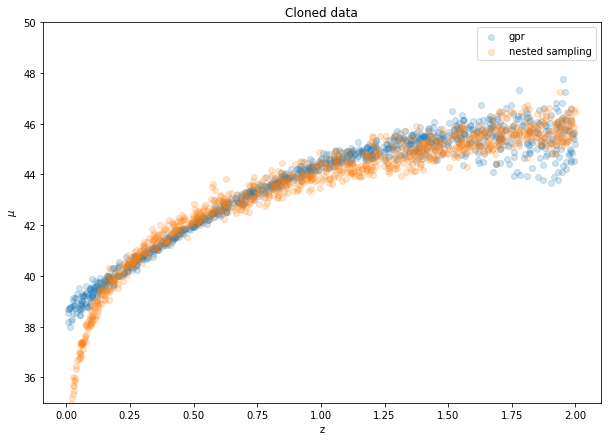

In [70]:
N = 1000

z = np.random.uniform(0,2,N)
mu_gpr = []
mu_lcdm = []


for i in z:
    
    # clone data with gpr
    mean, std = gpr.predict([[i]], return_std=True)
    mu_gpr.append(np.random.normal(loc=mean, scale=std, size=1))
    
    # clone data with LambdaCDM
    H0_mean, Om_mean = np.median(sample, axis=0)
    H0_std, Om_std = astroMLstats.sigmaG(sample, axis=0)
    H0 = np.random.normal(loc=H0_mean, scale=H0_std, size=1)[0]
    Om = np.random.normal(loc=Om_mean, scale=Om_std, size=1)[0]
    while Om<=0:
        Om = np.random.normal(loc=Om_mean, scale=Om_std, size=1)[0]
    par = [H0, Om]
    mu_lcdm.append(distmodz(par, i))
    '''
    
    Om, H0 = sample[np.random.choice(sample.shape[0])]
    par = [H0, Om]
    mu_lcdm.append(distmodz(par, i))'''
    
plt.figure(figsize=(10,7))
#plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='observations')
plt.scatter(z, mu_gpr, alpha=0.2, label='gpr')
plt.scatter(z, mu_lcdm, alpha=0.2, label='nested sampling')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.ylim(35,50)
plt.title('Cloned data')
plt.legend();

Notice that the distribution of observed z is not uniform! For GPR case, we are using a model trained on the distribution of observed z, which in our case is:

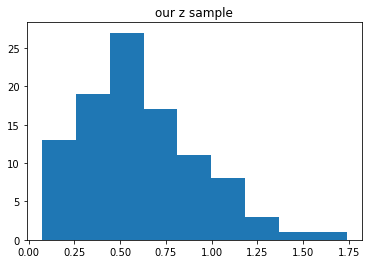

In [71]:
plt.hist(z_sample, bins=9)
plt.title('our z sample');

Since at the extremes we have little datapoints the GPR has high uncertainties in those regions and data cloned from GPR get apart from those cloned from the theoretical model.

What if we clone the z distribution?
Clone with inverse transform:

In [72]:
counts, bins= np.histogram(z_sample, bins=10, density=True)
bin_mid_loc = (bins[1:]+bins[:-1])/2

# take the cdf of the histogram H(x)
histogram_frac = counts/sum(counts)               
H = np.cumsum(histogram_frac) 

# take the inverse of the cdf
H_inv = scipy.interpolate.interp1d(H, bin_mid_loc)   #returns a function that has H as x, bin_mid_Loc as y

# generate random sample from U(0,2) and plug it in H^-1
u = np.random.uniform(H[0], H[-1], N)                 
zcloned = H_inv(u)

#plt.hist(zcloned, bins=30);

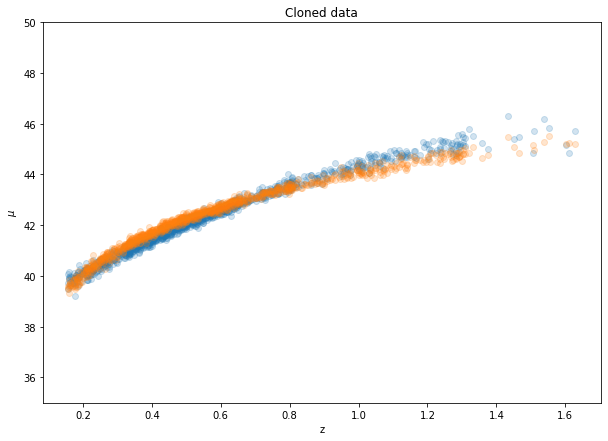

In [73]:
mu_gpr = []
mu_lcdm = []

for i in zcloned:
    
    # clone data with gpr
    mean, std = gpr.predict([[i]], return_std=True)
    mu_gpr.append(np.random.normal(loc=mean, scale=std, size=1))
    
    # clone data with LambdaCDM
    H0, Om = sample[np.random.choice(sample.shape[0])]
    par = [H0, Om]
    mu_lcdm.append(distmodz(par, i))
    
plt.figure(figsize=(10,7))
#plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='observations')
plt.scatter(zcloned, mu_gpr, alpha=0.2, label='gpr')
plt.scatter(zcloned, mu_lcdm, alpha=0.2, label='nested sampling')
plt.xlabel("z")
plt.ylabel("$\mu$")
#plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Cloned data');